# Velocity on a simulated 2D dataset

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import yaml
import torch

from simulate_2D import _generate_spline_basis, generate_adata
from splines_torch import torch_spline_basis_2d

## Construct branching velocity field

Manually set the spline weights to get a desired branching

In [29]:
w_omega_x = np.array([
    0.,  0.,  1.4, 1.4, 0.,  0.,
    0.,  0.,  1.4, 1.4, 0.,  0.,
    0.,  0.,  1.4, 1.4, 0.,  0.,
    0.5, 0.7, 1.4, 1.4, 0.7, 0.5, 
    0.4, 1.8, 0.2, 0.2, 1.8, 0.4,
    0.2, 0.1, 0.,  0.,  0.1, 0.2
])

w_omega_y = np.array([
    0.,   0.,   0.,   0.,   0.,   0.,
    0.,   0.,   0.,   0.,   0.,   0.,
    0.,   0.,   0.,   0.,   0.,   0.,
    0.,   -0.1, -1.5, 1.5,  0.1,  0.,
    -0.1, -1.2, -0.8, 0.8,  1.2,  0.1,
    -0.4, -0.4, 0.,   0.,   0.4,  0.4
])

w_omega = np.stack([w_omega_x, w_omega_y], axis=0)

In [30]:
n_cells = 1000
phi_x = np.linspace(0, 10, int(n_cells ** 0.5))
phi_y = np.linspace(0, 10, int(n_cells ** 0.5))
phi_grid = np.meshgrid(phi_x, phi_y)
phi_grid = np.stack(phi_grid, axis=0)
phi_grid = phi_grid.reshape(2, -1)

n_basis_omega = 6
knots_inner = torch.linspace(0, 10, n_basis_omega - 2)
knots_left = torch.full((3,), 0)
knots_right = torch.full((3,), 10)
knots_omega = torch.concatenate([knots_left, knots_inner, knots_right])

design_omega = torch_spline_basis_2d(
    phi_grid[0],
    phi_grid[1],
    t=knots_omega,
    k=3,
    c=None,
    prepend=None,
).T

omega = np.dot(w_omega, design_omega)

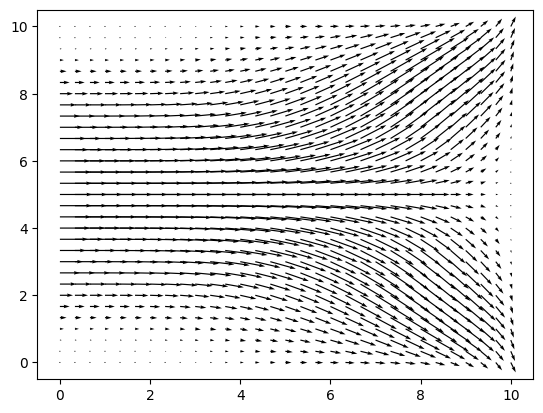

In [31]:
plt.quiver(*phi_grid, *(omega/2), scale=10)
plt.show()

In [32]:
np.save("w_omega.npy", w_omega)

## Example of generated adata

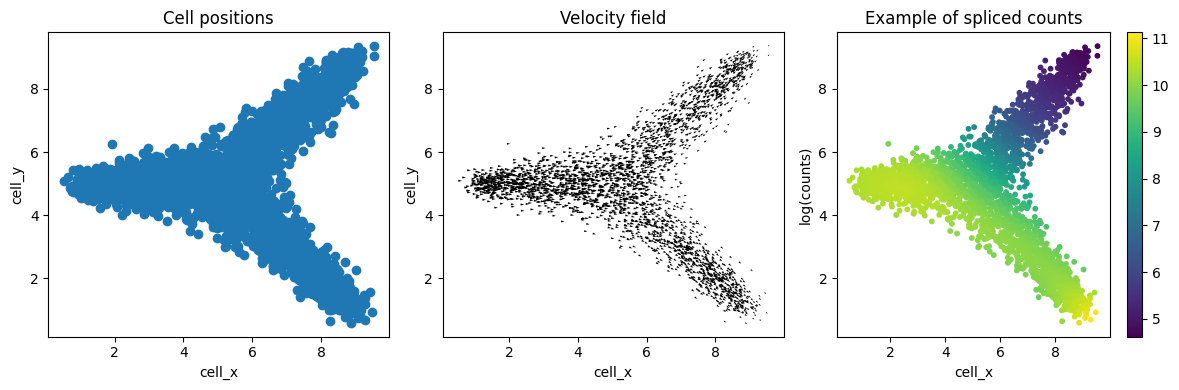

In [33]:
adata, spliced_exp, unspliced_exp = generate_adata(n_cells=3000, n_genes=300, seed=100,
                                plot=True, w_omega=w_omega)

PCA of the resulting data

In [34]:
adata.obs["phi1"] = adata.obsm["phi"][:, 0]
adata.obs["phi2"] = adata.obsm["phi"][:, 1]
sc.pp.pca(adata)

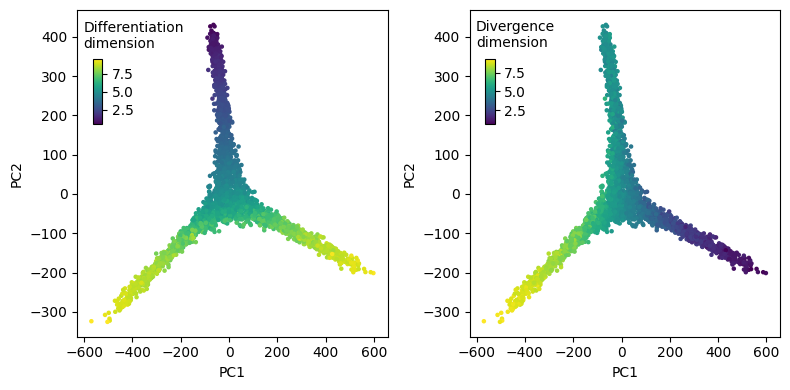

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.rcParams['pdf.fonttype'] = 42

ax = axs[0]
ax.scatter(adata.obsm["X_pca"][:, 0], adata.obsm["X_pca"][:, 1], c=adata.obs["phi1"], s=5, rasterized=True)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
cbar = fig.colorbar(ax.collections[0], ax=ax, cax=ax.inset_axes([0.05, 0.65, 0.03, 0.2]))
ax = cbar.ax
ax.text(-1, 11, "Differentiation\ndimension")

ax = axs[1]
ax.scatter(adata.obsm["X_pca"][:, 0], adata.obsm["X_pca"][:, 1], c=adata.obs["phi2"], s=5, rasterized=True)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
cbar = fig.colorbar(ax.collections[0], ax=ax, cax=ax.inset_axes([0.05, 0.65, 0.03, 0.2]))
ax = cbar.ax
ax.text(-1, 11, "Divergence\ndimension")

plt.tight_layout()
plt.savefig("figures/pca.pdf")
plt.show()

Different expression patterns

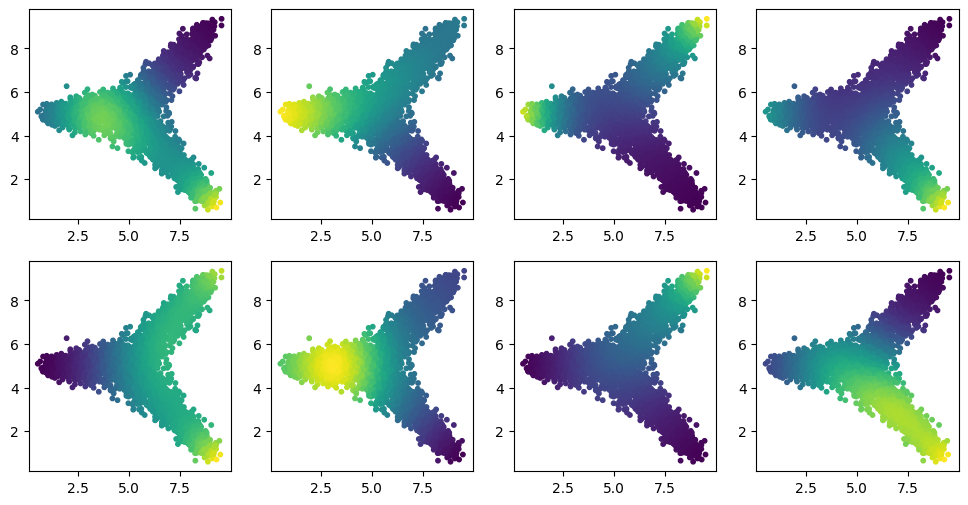

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axs.flatten()):
    ax.scatter(adata.obsm["phi"][:, 0], adata.obsm["phi"][:, 1], c=spliced_exp[i, :], s=10)

## Figures 

### Run simulations

Run this cell to generate all the files used downstream

In [12]:
# !python run_simulations.py

### Correlations

In [77]:
with open(f"results/correlations.yaml", "r") as f:
    corr_dict = yaml.safe_load(f)

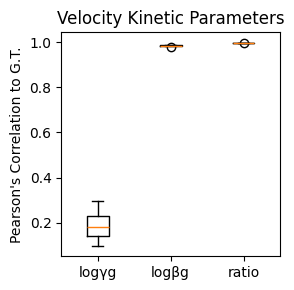

In [78]:
plt.figure(None, (3,3))
plt.rcParams['pdf.fonttype'] = 42
plt.boxplot([corr_dict["log_gamma"], corr_dict["log_beta"], corr_dict["ratio"]])
plt.xticks([1,2,3], ["logγg", "logβg", "ratio"])
plt.ylabel("Pearson's Correlation to G.T.")
plt.title("Velocity Kinetic Parameters")
plt.tight_layout()
plt.savefig("figures/kinetic_parameters.pdf")
plt.show()

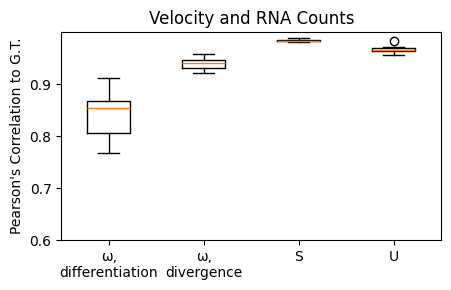

In [79]:
plt.figure(None, (4.7,3))
plt.rcParams['pdf.fonttype'] = 42
plt.boxplot([
    np.array(corr_dict["omega"])[:, 0],
    np.array(corr_dict["omega"])[:, 1],
    corr_dict["spliced"],
    corr_dict["unspliced"]
])
plt.xticks([1,2,3,4], ["ω,\ndifferentiation", "ω,\ndivergence", "S", "U"])
plt.ylabel("Pearson's Correlation to G.T.")
plt.title("Velocity and RNA Counts")
plt.tight_layout()
plt.ylim(0.6)
plt.savefig("figures/omega_counts.pdf")
plt.show()


### Examples

In [80]:
seed = 723
folder = f"results/sim_{seed}"
adata = sc.read_h5ad(f"{folder}/adata.h5ad")
phi = adata.obsm["phi"].T
result = np.load(f"{folder}/result.npy", allow_pickle=True).item()
spliced_gt = np.load(f"{folder}/spliced_exp.npy")
unspliced_gt = np.load(f"{folder}/unspliced_exp.npy")

Velocity, ground truth and estimated

In [82]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
kde.fit(phi.T)

n_points = 30
phi_grid = np.meshgrid(np.linspace(0, 10, n_points), np.linspace(0, 10, n_points))
phi_grid = np.stack(phi_grid, axis=0)
phi_grid = phi_grid.reshape(2, -1)

log_dens = kde.score_samples(phi_grid.T)
phi_masked = phi_grid[:, log_dens > np.percentile(log_dens, 70)]

_, _, _, design_omega = _generate_spline_basis(phi_grid, 0, 10)
omega_fit = np.dot(result["w_omega"], design_omega)
omega_gt = np.dot(w_omega, design_omega)
omega_masked = omega_fit[:, log_dens > np.percentile(log_dens, 70)]
omega_gt_masked = omega_gt[:, log_dens > np.percentile(log_dens, 70)]

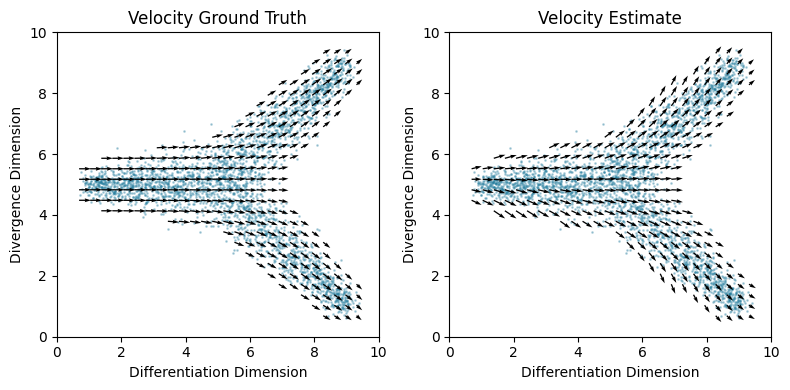

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.rcParams['pdf.fonttype'] = 42

ax = axs[0]
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.scatter(*phi, s=1, c='#227c9d', alpha=0.3, rasterized=True)
ax.quiver(*phi_masked, *omega_gt_masked, width=0.004, rasterized=True)
ax.set_title("Velocity Ground Truth")

ax = axs[1]
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.scatter(*phi, s=1, c='#227c9d', alpha=0.3, rasterized=True)
ax.quiver(*phi_masked, *omega_masked, width=0.004, rasterized=True)
ax.set_title("Velocity Estimate")

for ax in axs:
    ax.set_xlabel("Differentiation Dimension")
    ax.set_ylabel("Divergence Dimension")

fig.tight_layout()
plt.savefig("figures/velocity.pdf", dpi=300)
plt.show()

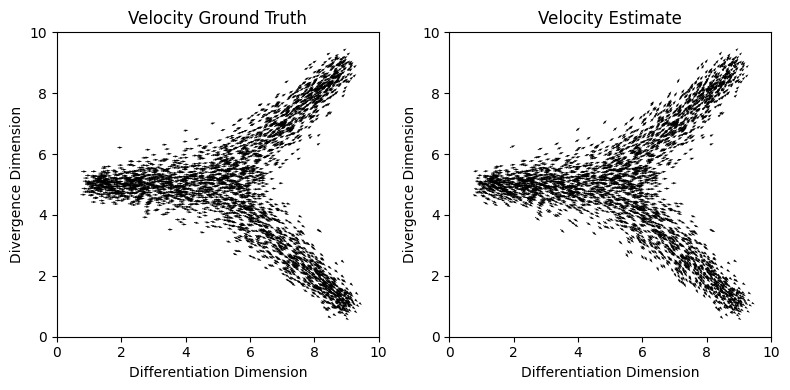

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.rcParams['pdf.fonttype'] = 42

ax = axs[0]
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.quiver(*phi, *adata.obsm["omega"].T, scale=100*np.mean(np.abs(adata.obsm["omega"])))
ax.set_title("Velocity Ground Truth")

ax = axs[1]
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.quiver(*phi, *result["omega"], scale=100*np.mean(np.abs(result["omega"])))
ax.set_title("Velocity Estimate")

for ax in axs:
    ax.set_xlabel("Differentiation Dimension")
    ax.set_ylabel("Divergence Dimension")

fig.tight_layout()
plt.show()

Gene expression, ground truth and estimated

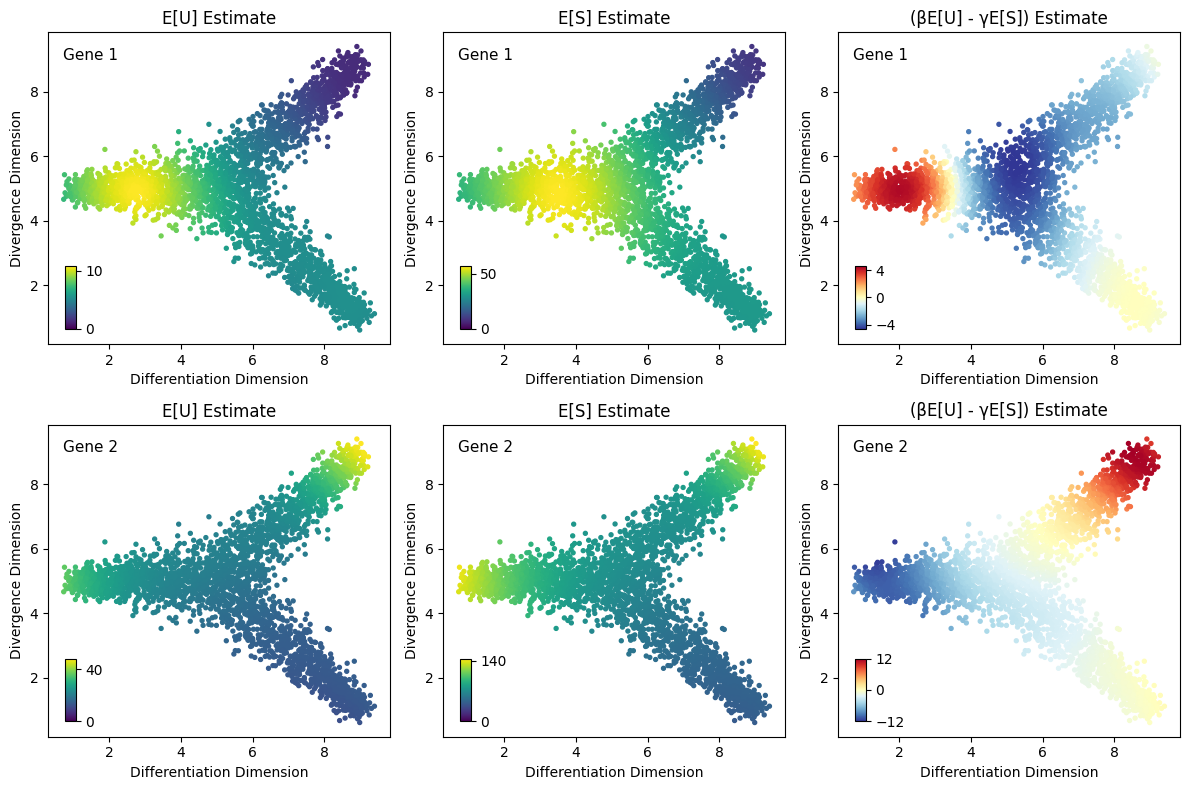

In [85]:
#gene_ids = [29, 134, 141, 149, 229, 253]
gene_ids = [29, 134]

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
plt.rcParams['pdf.fonttype'] = 42

for i, gene_i in enumerate(gene_ids):

    U = np.exp(result["ElogU"][gene_i, :])
    S = np.exp(result["ElogS"][gene_i, :])
    dSdt = np.exp(result["log_beta"])[gene_i] * U - np.exp(result["log_gamma"])[gene_i] * S

    axs_cur = axs[i]
    ax = axs_cur[0]
    ax.scatter(*phi, c=U, s=8, vmin=0, vmax=U.max(), rasterized=True)
    cbar_max = 10 * (U.max() // 10)
    fig.colorbar(axs_cur[0].collections[0], ax=axs_cur[0],
                 cax=axs_cur[0].inset_axes([0.05, 0.05, 0.03, 0.2]),
                 ticks=[0, cbar_max])
    ax.set_title("E[U] Estimate")

    ax = axs_cur[1]
    ax.scatter(*phi, c=S, s=8, vmin=0, vmax=S.max(), rasterized=True)
    cbar_max = 10 * (S.max() // 10)
    fig.colorbar(axs_cur[1].collections[0], ax=axs_cur[1],
                 cax=axs_cur[1].inset_axes([0.05, 0.05, 0.03, 0.2]),
                 ticks=[0, cbar_max])
    ax.set_title("E[S] Estimate")

    ax = axs_cur[2]
    vmin = (dSdt).min()
    vmax = (dSdt).max()
    vmin = -max(abs(vmin), abs(vmax))
    vmax = -vmin
    ax.scatter(*phi, c=dSdt, s=8, vmin=vmin, vmax=vmax, cmap="RdYlBu_r", rasterized=True)
    cbar_max = math.floor(vmax)
    fig.colorbar(axs_cur[2].collections[0], ax=axs_cur[2],
                 cax=axs_cur[2].inset_axes([0.05, 0.05, 0.03, 0.2]),
                 ticks=[-cbar_max, 0, cbar_max])
    ax.set_title("(βE[U] - γE[S]) Estimate")

    for ax in axs_cur:
        ax.text(x=0.7, y=9, s=f"Gene {i+1}", fontsize=11)

for ax in axs.ravel():
    ax.set_xlabel("Differentiation Dimension")
    ax.set_ylabel("Divergence Dimension")

fig.tight_layout()
plt.savefig("figures/genes.pdf", dpi=300)
plt.show()

Gene expression on a 3D plot

In [139]:
X, Y = np.meshgrid(np.linspace(0, 10, n_points), np.linspace(0, 10, n_points))

n_basis = 6
degree = 3
knots_left = np.full((3,), 0)
knots_right = np.full((3,), 10)
knots_inner = np.linspace(0, 10, n_basis - 2)
knots_s = np.concatenate([knots_left, knots_inner, knots_right])
design_s = torch_spline_basis_2d(X.ravel(), Y.ravel(), t=knots_s, 
                                 k=degree, c=None, prepend=1).T.numpy()

S_grid = np.dot(result["w_s"], design_s)

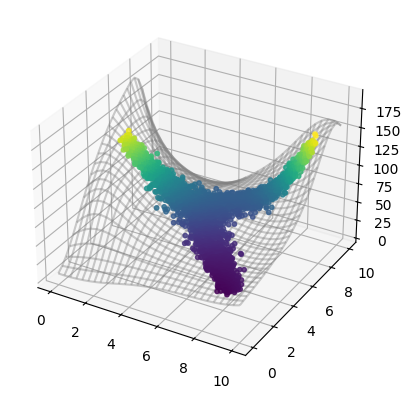

In [156]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d', 'computed_zorder':False})
plt.rcParams['pdf.fonttype'] = 42

gene_i = 134
U = np.exp(result["ElogU"][gene_i, :])
S = np.exp(result["ElogS"][gene_i, :])
dSdt = np.exp(result["log_beta"])[gene_i] * U - np.exp(result["log_gamma"])[gene_i] * S

ax.plot_wireframe(X, Y, np.exp(S_grid[gene_i].reshape(n_points, n_points)), color='grey', alpha=0.4, zorder=1)
ax.scatter(*phi, S, c=S, s=10, rasterized=True, zorder=2, alpha=0.8)

plt.show()